In [1]:
from pythonfiles.data_class import *
from pythonfiles.generator import GenModel
from pythonfiles.discriminator import DisModel
from pythonfiles.model_utility import *


from torchsummary import summary
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
hparams = {
    'z_shape': 128,
    'gen_final_layer_size': 3,
    'image_input_shape': 64,
    'batch_size': 180,
    'epochs': 2
}


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the  Device - ", device)

Using the  Device -  cuda:0


In [4]:

gen_model = GenModel(hparams)
dis_model = DisModel(hparams)

dis_model = dis_model.apply(init_weights)
gen_model = gen_model.apply(init_weights)

dis_model = dis_model.to(device)
gen_model = gen_model.to(device)

In [5]:

gen_optimizer = torch.optim.Adam(gen_model.parameters(),lr=0.0002,betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(dis_model.parameters(),lr=0.0002,betas=(0.5, 0.999))
loss_function = torch.nn.BCELoss(reduction='mean')

In [6]:
 logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
 writer = SummaryWriter(logdir)

In [7]:
from torchsummary import summary
#gen_model = GenModel(hparams)
#gen_model.cuda()
summary(gen_model,(128,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 12, 3, 3]          13,836
       BatchNorm2d-2             [-1, 12, 3, 3]              24
             PReLU-3             [-1, 12, 3, 3]               1
   ConvTranspose2d-4             [-1, 24, 5, 5]           2,616
       BatchNorm2d-5             [-1, 24, 5, 5]              48
             PReLU-6             [-1, 24, 5, 5]               1
   ConvTranspose2d-7             [-1, 36, 7, 7]           7,812
       BatchNorm2d-8             [-1, 36, 7, 7]              72
             PReLU-9             [-1, 36, 7, 7]               1
  ConvTranspose2d-10             [-1, 48, 9, 9]          15,600
      BatchNorm2d-11             [-1, 48, 9, 9]              96
            PReLU-12             [-1, 48, 9, 9]               1
  ConvTranspose2d-13           [-1, 72, 11, 11]          31,176
      BatchNorm2d-14           [-1, 72,

In [8]:
real_dataloader = data_setup(batch_size=hparams['batch_size'])
real_label = torch.ones(hparams['batch_size'], 1,device=device)
fake_label = torch.zeros(hparams['batch_size'], 1,device=device)

In [9]:
dis_fn_real_list = []
dis_fn_fake_list = []

dis_loss_list = []
gen_loss_list = []
cntr = 0
for epoch in tqdm(range(hparams['epochs'])):
    for data in tqdm(real_dataloader):

        dis_model.zero_grad()

        # Discriminator update for real data
        data = data[0]
        data = data.to(device)

        real_outputs = dis_model(data)
        dis_fn_real_list.append(torch.mean(real_outputs.detach().cpu()))
        writer.add_scalar('Discriminator Function Real',
                          torch.mean(real_outputs.detach().cpu()), cntr)
        real_loss = loss_function(real_outputs, real_label)
        real_loss.backward()
        running_real_loss = real_loss.item()

        # Discriminator update for fake data

        fake_noise = torch.randn(
            hparams['batch_size'], hparams['z_shape'], 1, 1, device=device)
        fake_image = gen_model(fake_noise)
        fake_outputs = dis_model(fake_image.detach())
        dis_fn_fake_list.append(torch.mean(fake_outputs.detach().cpu()))
        writer.add_scalar('Discriminator Function Fake',
                          torch.mean(fake_outputs.detach().cpu()), cntr)

        fake_loss = loss_function(fake_outputs, fake_label)
        fake_loss.backward()
        running_fake_loss = fake_loss.item()
        dis_loss = running_fake_loss+running_real_loss

        dis_loss_list.append(dis_loss)
        writer.add_scalar('Discriminator Loss',
                          running_fake_loss+running_real_loss, cntr)

        dis_optimizer.step()

        # Generator update

        # fake_noise = torch.randn(
        #   hparams['batch_size'], hparams['z_shape'], 1, 1,device=device)
        #fake_image = gen_model(fake_noise)
        fake_outputs = dis_model(fake_image.detach())

        gen_loss = loss_function(fake_outputs, real_label)
        running_gen_loss = gen_loss.item()
        gen_loss_list.append(running_gen_loss)
        writer.add_scalar('Generator Loss', running_gen_loss, cntr)
        gen_loss.backward()
        gen_optimizer.step()

        cntr += 1

       
         

    torch.save(dis_model.state_dict(), "dis"+str(epoch))
    torch.save(gen_model.state_dict(), "gen"+str(epoch))


  6%|▌         | 62/1125 [00:17<04:29,  3.95it/s]

In [10]:
fake_image.shape

torch.Size([100, 3, 64, 64])

(64, 64, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


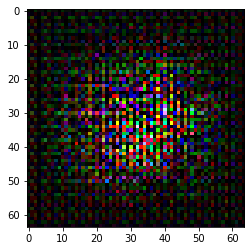

In [11]:

img_out=fake_image[2].detach().cpu().numpy()
img_out=np.swapaxes(img_out,0,2)
print(img_out.shape)
plt.imshow(img_out)